In [1]:
%cd ..
%cd ..

/home/ltorres/leo/tesis/cloud-classification/code/notebooks
/home/ltorres/leo/tesis/cloud-classification/code


In [2]:
%load_ext autoreload
%autoreload 2

---

In [3]:
from torchvision.io import read_image
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from random import sample
import torch
import torch.nn as nn
from torch.optim import lr_scheduler

In [4]:
from src.dataset import GCD
from src import config
from src import engine_gnn as engine
from src import utils

from src.models.graph_nets import GraphConvGNN, GATConvGNN

from notebooks.adjacency_construction.adjacency_models import *

In [5]:
from sklearn.metrics import accuracy_score

In [6]:
import wandb

#### PARAMS

In [7]:
device = 'cuda:1'


BUILDER = 'transformer'
builder_name = "Transformer Encoder"

LR = 3e-4
EPOCHS = 15



exp_name = 'shuffle_5_TRANSFORMER_ENCODER_06_04_22'
model_filename = f'/adjacency_builders/{exp_name}.pt'

---

In [8]:
wandb.login()

wandb: Currently logged in as: leonardtd (use `wandb login --relogin` to force relogin)


True

#### Data loaders

In [9]:
path_train_images = utils.get_gcd_paths(config.DATA_DIR,'train')

In [10]:
train_dataset = GCD(path_train_images, resize=256)

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=4,
        shuffle=True,
    )

In [11]:
path_test_images = utils.get_gcd_paths(config.DATA_DIR,'test')

test_dataset = GCD(path_test_images, resize=256)

test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=4,
        shuffle=True,
    )

### Data augmentation data loaders

In [12]:
aug_dataset = GCD(path_train_images, resize=256, aug_types='augmentation')

augmentation_loader = torch.utils.data.DataLoader(
        aug_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=4,
        shuffle=True,
    )

---

#### Model

In [13]:
from torchvision import models

In [37]:
torch.cuda.empty_cache()

In [15]:
model = GATConvGNN(7, 1024, 2, 4, 0.7, device, adjacency_builder = BUILDER).to(device)

Transformer has 4 blocks


In [16]:
criterion = utils.loge_loss
optimizer  = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

####  wandb

In [17]:
wandb.init(
    # Set the project where this run will be logged
    project="cloud classification - shuffle",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=exp_name, 
    # Track hyperparameters and run metadata
    config={
    "learning_rate": LR,
    "architecture": "GATConvGNN",
    "loss": "LogeLoss",
    "optim": "SGD",
    "dataset": "GCD",
    "builder": f"{builder_name}",
    "epochs": EPOCHS,
  })

### Train

In [18]:
best_accuracy=0
best_iteration=0
best_params={}

for e in range(EPOCHS):
    ### TRAIN DATASET
    preds, targets, loss = engine.train_fn(model, train_loader, criterion, optimizer, device=device)
    train_acc = accuracy_score(targets, preds)
    
    ### AUGMENTATION IMAGES
    engine.forward_backward_pass(model, augmentation_loader, criterion, optimizer, device=device)
    
    scheduler.step()
    
    test_preds, test_targets, test_loss = engine.eval_fn(model, test_loader, criterion, device=device)
    test_acc = accuracy_score(test_targets, test_preds)
    
    if test_acc > best_accuracy:
        torch.save(model.state_dict(), config.SAVE_PATH+model_filename)
        print(f"Saved best parameters at epoch {e+1}")
        best_accuracy = test_acc
        best_iteration = e+1
        best_params = model.state_dict()
    
    print("EPOCH {}: Train acc: {:.2%} Train Loss: {:.4f} Test acc: {:.2%} Test Loss: {:.4f}".format(
        e+1,
        train_acc,
        loss,
        test_acc,
        test_loss
    ))
    
    metrics = {
                "train/train_loss": loss,
                "train/train_accuracy": train_acc,
                "test/test_loss": test_loss,
                "test/test_accuracy": test_acc,
              }

    wandb.log(metrics)


100%|██████████| 282/282 [00:18<00:00, 15.62it/s]


Saved best parameters at epoch 1
EPOCH 1: Train acc: 68.36% Train Loss: 1.9579 Test acc: 60.92% Test Loss: 1.9842


100%|██████████| 282/282 [00:17<00:00, 15.75it/s]


Saved best parameters at epoch 2
EPOCH 2: Train acc: 86.27% Train Loss: 0.8196 Test acc: 67.63% Test Loss: 1.7440


100%|██████████| 282/282 [00:17<00:00, 15.73it/s]


EPOCH 3: Train acc: 89.17% Train Loss: 0.6432 Test acc: 62.08% Test Loss: 1.8387


100%|██████████| 282/282 [00:18<00:00, 15.66it/s]


EPOCH 4: Train acc: 90.31% Train Loss: 0.5597 Test acc: 63.18% Test Loss: 1.8752


100%|██████████| 282/282 [00:17<00:00, 15.68it/s]


EPOCH 5: Train acc: 91.87% Train Loss: 0.4899 Test acc: 65.53% Test Loss: 1.7570


100%|██████████| 282/282 [00:18<00:00, 15.66it/s]


EPOCH 6: Train acc: 93.04% Train Loss: 0.4242 Test acc: 65.66% Test Loss: 1.7446


100%|██████████| 282/282 [00:17<00:00, 15.68it/s]


EPOCH 7: Train acc: 94.31% Train Loss: 0.3477 Test acc: 65.37% Test Loss: 1.7728


100%|██████████| 282/282 [00:18<00:00, 15.62it/s]


EPOCH 8: Train acc: 94.80% Train Loss: 0.3115 Test acc: 65.01% Test Loss: 1.7906


100%|██████████| 282/282 [00:18<00:00, 15.59it/s]


EPOCH 9: Train acc: 95.88% Train Loss: 0.2670 Test acc: 64.24% Test Loss: 1.7957


100%|██████████| 282/282 [00:18<00:00, 15.58it/s]


EPOCH 10: Train acc: 96.41% Train Loss: 0.2338 Test acc: 64.88% Test Loss: 1.7935


100%|██████████| 282/282 [00:18<00:00, 15.61it/s]


EPOCH 11: Train acc: 97.05% Train Loss: 0.1805 Test acc: 67.48% Test Loss: 1.7194


100%|██████████| 282/282 [00:18<00:00, 15.57it/s]


EPOCH 12: Train acc: 97.92% Train Loss: 0.1357 Test acc: 63.30% Test Loss: 1.8009


100%|██████████| 282/282 [00:18<00:00, 15.66it/s]


EPOCH 13: Train acc: 98.08% Train Loss: 0.1284 Test acc: 66.14% Test Loss: 1.7585


100%|██████████| 282/282 [00:17<00:00, 15.70it/s]


EPOCH 14: Train acc: 98.21% Train Loss: 0.1153 Test acc: 61.29% Test Loss: 1.8759


100%|██████████| 282/282 [00:18<00:00, 15.65it/s]

EPOCH 15: Train acc: 98.45% Train Loss: 0.1023 Test acc: 61.23% Test Loss: 1.8686


In [19]:
wandb.finish()

test/test_accuracy,▁█▂▃▆▆▆▅▄▅█▃▆▁▁
test/test_loss,█▂▄▅▂▂▂▃▃▃▁▃▂▅▅
train/train_accuracy,▁▅▆▆▆▇▇▇▇██████
train/train_loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
test/test_accuracy,0.61233
test/test_loss,1.86859
train/train_accuracy,0.9845
train/train_loss,0.10233


In [27]:
model.load_state_dict(torch.load(config.SAVE_PATH+model_filename))

<All keys matched successfully>

In [28]:
test_preds, test_targets, test_loss = engine.eval_fn(model, test_loader, criterion, device=device)

100%|██████████| 282/282 [00:17<00:00, 15.93it/s]


In [29]:
accuracy_score(test_targets, test_preds)

0.671

---

### Accuracy per class and confusion matrix

In [30]:
class_mapper = {
    0: '1_cumulus',
    1: '2_altocumulus',
    2: '3_cirrus',
    3: '4_clearsky',
    4: '5_stratocumulus',
    5: '6_cumulonimbus',
    6: '7_mixed',
}

In [31]:
class_acc = dict()
matrix = np.zeros((7,7), dtype=int)

for i in range(7):
    pred_index = np.where(test_targets==i)[0]
    class_acc[class_mapper[i]] = accuracy_score(test_targets[pred_index], test_preds[pred_index])
    
    for j in test_preds[pred_index]:
        matrix[i,j]+=1 

In [32]:
class_acc

{'1_cumulus': 0.5426666666666666,
 '2_altocumulus': 0.13733333333333334,
 '3_cirrus': 0.8671978751660027,
 '4_clearsky': 0.8244178728760226,
 '5_stratocumulus': 0.635195530726257,
 '6_cumulonimbus': 0.8609199565374864,
 '7_mixed': 0.085667215815486}

Global Test accuracy 0.671


<AxesSubplot:title={'center':'Confusion Matrix (Accuracy %)'}>

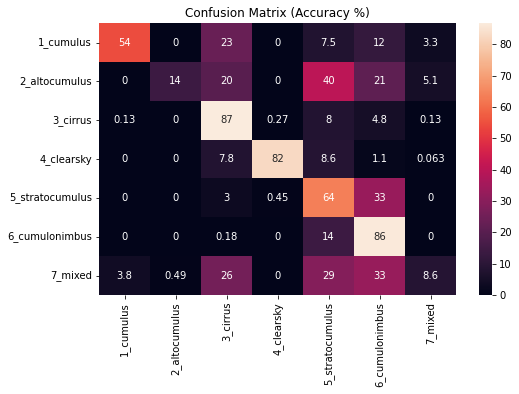

In [33]:
print(f"Global Test accuracy {accuracy_score(test_targets, test_preds)}")

sum_of_rows = matrix.sum(axis=1)
conf_mat = 100*matrix / sum_of_rows[:, np.newaxis]

df_cm = pd.DataFrame(conf_mat, index = class_acc.keys(),
                  columns = class_acc.keys())

plt.figure(figsize = (8,5))
plt.title("Confusion Matrix (Accuracy %)")
sns.heatmap(df_cm, annot=True)